# Differences between DPI and MDI Inhaler Prescribing in England: Step-by-step Analysis (2023)

 <a id='toc'></a>
<div style="
    background-color: #f0f0f0;  /* Light green - pharmacy theme */
    padding: 25px;
    border-radius: 10px;
    border-left: 5px solid #1976d2;  /* Darker green accent */
    margin: 20px 0;
    box-shadow: 0 2px 4px rgba(0,0,0,0.1);  /* Subtle shadow for depth */
">
    <h2 style="color: #000000; margin-top: 0;">
        📑 Table of Contents
    </h2>
    <ul style="color: #000000;">
        <li><a href="#Intro" style="color: #1976d2;">Introduction</a></li>
        <li><a href="#setup" style="color: #1976d2;">Setting up our tools</a></li>
        <li><a href="#f1" style="color: #1976d2;">Understanding How Inhalers Are Classified</a></li>
        <li><a href="#f2" style="color: #1976d2;"> Restrict to Respiratory Medicines Only</a></li>
    <li><a href="#f3" style="color: #1976d2;">Label Each Inhaler by Device Type</a></li>        
        <li><a href="#f4" style="color: #1976d2;">Adding ATC Codes</a></li>              
        <li><a href="#f5" style="color: #1976d2;"> Quality Check - Finding Missing or Misclassified Products</a></li>
        <li><a href="#f6" style="color: #1976d2;">Analysing 2023 Prescribing Data</a></li>                  <li><a href="#f7" style="color: #1976d2;">Breakdown prescribing by ATC Category</a></li>
        <li><a href="#f8" style="color: #1976d2;">Visualising Our Findings</a></li>   
        <li><a href="#f9" style="color: #1976d2;">Quality Assurance - Checking Our Classifications</a></li> 
        <!-- Add more items -->
    </ul>
</div>

 <a id='Intro'></a>
### Introduction
This notebook has been developed to support the Heidelberg Institute's initiative to analyse climate-sensitive inhaler prescribing patterns in selected European countries in 2023. It specifically focuses on prescriptions clustered by Anatomical Therapeutic Chemical (ATC) codes, categorised into:

-   Short-acting beta-agonists (**SABA**)
-   Long-acting beta-agonists (**LABA**)
-   **Anticholinergic Drugs**
-   Inhaled corticosteroids (**ICS**)
-   Adrenergics in combination with corticosteroids or other drugs, excl. anticholinergics (**Combi_1**)
-   Adrenergics in combination with anticholinergics incl. triple combinations with corticosteroids ((**Combi_2**)

Additionally, the inhalers are differentiated by device type:

-   **Pressurised Metered Dose Inhalers (pMDI)**: Known for higher carbon footprints.
-   **Dry Powder Inhalers (DPI)**: Lower environmental impact compared to pMDIs.

A third category is also available:
-   **Soft Mist Inhalers (SMI)**: These have a lower carbon footprint compared to pMDIs, but differ from DPIs and are therefore analysed separately.

#### **What the steps are:**

- Identifying all inhaler devices.
- Link these inhalers to their BNF codes and limit to respiratory medications.
- Classify inhalers by type (DPI, MDI, SMI).
- Add ATC codes to inhaler data.
- Extract and summarise prescribing data for 2023.
- Check and save data at each stage.

**Entity Relationship Diagram (ERD):**

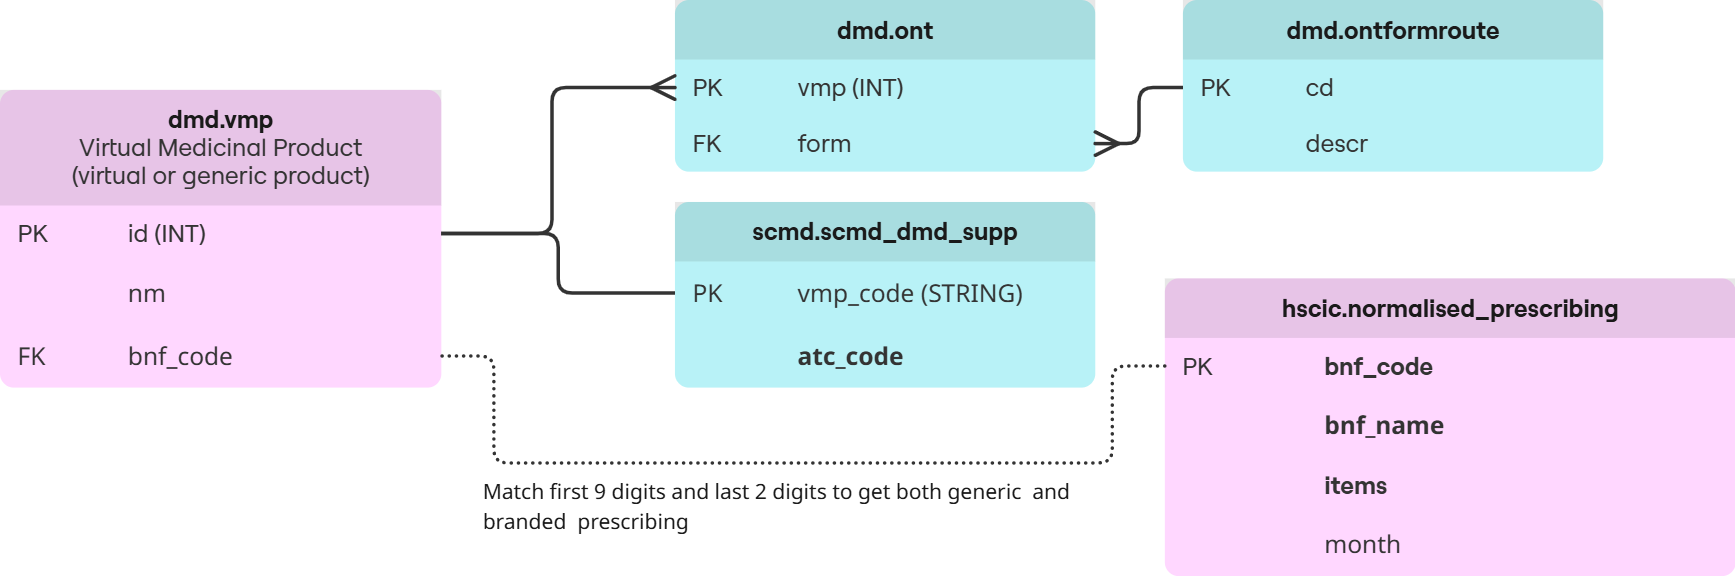

The ERD diagram  above shows the tables from the Dictionary of Medicines and Devices (dm+d) dataset used in this analysis. The dm+d is the NHS national standard database for medicines and medical devices, containing details about drugs, including codes, names, and mappings. The dataset is made available by the NHS Business Services Authority (NHSBSA) through the [NHS TRUD](onenote:#Chris%20notebook&section-id={3C5B1879-80B3-45D1-A622-F09202323047}&page-id={0A97DF0F-8AE6-4652-9AB3-AA333872F0FE}&object-id={815FC114-B71A-0840-2737-61A2662D26CC}&A4&base-path=https://unioxfordnexus-my.sharepoint.com/personal/prhc1002_ox_ac_uk/Documents/Caroline%20@%20Nexus365/Prescribing%20database.one) (Technology Reference Update Distribution) portal.

**Key Tables in the ERD:**

-   **`dmd.vmp`**: Contains each inhaler's unique VMP identifier (`id`), its name (`nm`), BNF code (`bnf_code`) and additional metadata.

-   **`dmd.ont`**: Links each VMP (`vmp`) to a specific form code (`form`). This code connects to `dmd.ontformroute`, providing a descriptive form (`descr`), such as `powderinhalation.inhalation` for DPI or `pressurizedinhalation.inhalation` for MDI.

-   **`scmd.scmd_dmd_supp`**: Matches a VMP code (`vmp_code`) with its associated Anatomical Therapeutic Chemical (ATC) code (`atc_code`).

-   **`hscic.normalised_prescribing`**: Records prescribing activity data, including BNF code, number of items prescribed, quantity, and prescribing month.

<div style="text-align: right; margin-top: 20px;">
    <a href="#toc" style="color: #1976d2; text-decoration: none;">
        ↑ Back to Table of Contents
    </a>
</div>

<a id='setup'></a>
### Setting Up Our Tools

In [1]:
# Import the libraries we need:
from ebmdatalab import bq                  # Connects us to the prescribing database
import pandas as pd                        # Our main tool for handling data tables
import matplotlib.pyplot as plt           # Creates charts and graphs
import numpy as np                         # Helps with numerical calculations
import os                                  # Manages file paths

# This setting ensures we can see full product names in our results
pd.set_option('display.max_colwidth', None)


<div style="text-align: right; margin-top: 20px;">
    <a href="#toc" style="color: #1976d2; text-decoration: none;">
        ↑ Back to Table of Contents
    </a>
</div>

 <a id=f1></a>
### Step 1: Understanding How Inhalers Are Classified

To begin with, let's explore how the NHS Dictionary of Medicines and Devices (dm+d) classifies inhalers. 

#### First, let's see all inhalation route descriptions:
The dmd dataset has a table **`ontformroute`** with Ontology Form & Route associated with each VMP. We use this to search for all products with "inhalation" in the description, to identify which descriptions might specifically match to inhalers.

In [2]:
# SQL: Find all formroute descriptions containing 'inhalation'
sql_inhalation_forms = """
  SELECT
    descr
  FROM `ebmdatalab.dmd..ontformroute` AS r
  WHERE LOWER(r.descr) LIKE '%inhalation'
"""

#Result will be cached to a csv file. If the CSV already exists it will be loaded into a pandas DataFrame
#This means that we don’t hit the BigQuery API every time we run the script. We re-use the cached CSV instead.
df_inhalation = bq.cached_read(
    sql_inhalation_forms,
    csv_path=os.path.join('..', 'data', 'v2', 'interim_file_inhalation_form_types.csv')
)                            
#client.query(sql_inhalation_forms).to_dataframe()

**This query will process 9.69 KB when run.**

In [3]:
print(df_inhalation)

                                descr
0    pressurizedinhalation.inhalation
1         powderinhalation.inhalation
2        solutionnebuliser.inhalation
3     suspensioninhalation.inhalation
4      suspensionnebuliser.inhalation
5         vapourinhalation.inhalation
6            gasinhalation.inhalation
7              liquiddrops.inhalation
8     impregnatedcigarette.inhalation
9       inhalationsolution.inhalation
10     dispersionnebuliser.inhalation
11  vapourinhalationliquid.inhalation



#### We now look at examples of each description above:

In [4]:
sql_inhalation_form_samples = """

-- Query to find 3 product examples for each specific inhalation route type
WITH inhalation_products AS (
  -- Step 1: Join tables to connect Virtual Medicinal Products (VMP) with their route descriptions
  -- Following the ERD: dmd.vmp -> dmd.ont -> dmd.ontformroute
  SELECT 
    v.nm AS product_name,                                    -- Product name from VMP table
    r.descr AS route_description,                           -- Route description (e.g., "powderinhalation.inhalation")
    ROW_NUMBER() OVER (PARTITION BY r.descr ORDER BY v.nm) AS rn  -- Rank products within each route type (alphabetically)
  FROM 
    ebmdatalab.dmd.vmp v                                               -- Virtual Medicinal Product table (contains product info)
    LEFT JOIN ebmdatalab.dmd.ont o ON v.id = o.vmp                   -- Join via ont table (links VMP to form routes)
    LEFT JOIN ebmdatalab.dmd.ontformroute r ON o.form = r.cd         -- Join to get route descriptions
  WHERE 
    -- Step 2: Filter for the exact matches from the earlier query results    
    LOWER(r.descr) IN (
      'pressurizedinhalation.inhalation',    
      'powderinhalation.inhalation',         
      'solutionnebuliser.inhalation',        
      'suspensioninhalation.inhalation',     
      'suspensionnebuliser.inhalation',      
      'vapourinhalation.inhalation',         
      'gasinhalation.inhalation',            
      'liquiddrops.inhalation',              
      'impregnatedcigarette.inhalation',     
      'inhalationsolution.inhalation',       
      'dispersionnebuliser.inhalation',      
      'vapourinhalationliquid.inhalation'    
    )
)
-- Step 3: Select final results, limiting to 5 examples per route type
SELECT 
  route_description,                                        -- Show the route description
  product_name                                             -- Show the product name
FROM 
  inhalation_products
WHERE 
  rn <= 5                                                  -- Limit to top 5 products per route (alphabetically first)
ORDER BY 
  route_description,                                       -- Group by route type
  product_name;         
  """
df_inhalation_form_samples = bq.cached_read(
   sql_inhalation_form_samples,
    csv_path=os.path.join('..', 'data', 'v2', 'interim_file_inhalation_form_samples.csv')
) 

**This query will process 1.67 MB when run.**

In [5]:
display(df_inhalation_form_samples)

,route_description,product_name
0,dispersionnebuliser.inhalation,Amikacin liposomal 590mg nebuliser dispersion vials with device
1,gasinhalation.inhalation,Air
2,gasinhalation.inhalation,Air cylinders 1280litres
3,gasinhalation.inhalation,Air cylinders 3200litres
4,gasinhalation.inhalation,Air cylinders 5200litres
5,gasinhalation.inhalation,Air cylinders 6400litres
6,impregnatedcigarette.inhalation,Diamorphine 100mg impregnated cigarettes
7,impregnatedcigarette.inhalation,Diamorphine 120mg impregnated cigarettes
8,impregnatedcigarette.inhalation,Diamorphine 20mg impregnated cigarettes
9,impregnatedcigarette.inhalation,Diamorphine 30mg impregnated cigarettes


The sample products can now be reviewed to check whether or not each description matches an inhaler.
*True inhalers* (hand-held, metered devices) appear under:
-   *inhalationsolution.inhalation* → SMIs
-   *powderinhalation.inhalation* → DPIs
-   *pressurizedinhalation.inhalation* → pMDIs
  
Everything else is either a *nebuliser product*, a *gas cylinder*, a *vapour/anesthetic liquid*, or *cigarettes*, and so does **not** match the standard inhaler definition.


#### We can now write a query to identify all inhaler devices:

In [6]:
sql_inhaler_forms = """
SELECT
  o.vmp        AS vmp_code,
  v.nm         AS vmp_name,
  r.descr      AS form_descr
FROM `ebmdatalab.dmd.vmp`       AS v
LEFT JOIN `ebmdatalab.dmd.ont`      AS o
  ON v.id = o.vmp
LEFT JOIN `ebmdatalab.dmd.ontformroute` AS r
  ON o.form = r.cd
WHERE r.descr IN (
  'powderinhalation.inhalation',      
  'pressurizedinhalation.inhalation',
  'inhalationsolution.inhalation'    
);
"""
inhaler_forms = bq.cached_read(
   sql_inhaler_forms,
    csv_path=os.path.join('..', 'data', 'v2', 'interim_file_inhaler_forms.csv')
)

**This query will process 1.67 MB when run.**

In [7]:
display(inhaler_forms.head(15))

,vmp_code,vmp_name,form_descr
0,44098611000001100,Generic Pulmotec 1.34g kit for radiopharmaceutical preparation 135microlitre crucibles,powderinhalation.inhalation
1,44098711000001109,Generic Pulmotec 1.34g kit for radiopharmaceutical preparation 300microlitre crucibles,powderinhalation.inhalation
2,39488111000001102,Pentetic acid 20.8mg kit for radiopharmaceutical preparation,inhalationsolution.inhalation
3,32687711000001109,Loxapine 9.1mg/dose inhalation powder,powderinhalation.inhalation
4,20514511000001105,Mannitol 40mg inhalation powder capsules with device,powderinhalation.inhalation
5,15424511000001100,Mannitol 5mg inhalation powder capsules,powderinhalation.inhalation
6,15425411000001103,Mannitol 10mg inhalation powder capsules,powderinhalation.inhalation
7,15426011000001103,Mannitol 20mg inhalation powder capsules,powderinhalation.inhalation
8,15426411000001107,Mannitol 40mg inhalation powder capsules,powderinhalation.inhalation
9,15427011000001100,Generic Osmohale empty inhalation powder capsules,powderinhalation.inhalation


Reviewing the list reveals that it contains some inhaler products not intended for respiratory conditions. We can address this in the next stage.

<div style="text-align: right; margin-top: 20px;">
    <a href="#toc" style="color: #1976d2; text-decoration: none;">
        ↑ Back to Table of Contents
    </a>
</div>

 <a id='f2'></a>
### **Step 2**: Restrict to Respiratory Medicines Only

Not all inhalers are for respiratory conditions. We'll filter to keep only respiratory medicines using BNF chapter `'03'`. To do this, we will need to link the inhalers to their BNF codes.

In [8]:
sql_respiratory = """
# Link inhalers to BNF codes and keep only respiratory medicines
# BNF codes starting with '03' are respiratory system drugs

SELECT
  f.vmp_code,
  f.vmp_name,
  f.form_descr,
  v.bnf_code
FROM (
  -- This subquery gets all our inhalers as identified in Step 1
  SELECT
    o.vmp        AS vmp_code,
    v.nm         AS vmp_name,
    r.descr      AS form_descr
  FROM `ebmdatalab.dmd.vmp`         AS v
  LEFT JOIN `ebmdatalab.dmd.ont`        AS o
    ON v.id = o.vmp
  LEFT JOIN `ebmdatalab.dmd.ontformroute` AS r
    ON o.form = r.cd
  WHERE r.descr IN (
    'powderinhalation.inhalation',
    'pressurizedinhalation.inhalation',
    'inhalationsolution.inhalation'
  )
) AS f
JOIN `ebmdatalab.dmd.vmp` AS v
  ON f.vmp_code = v.id
WHERE v.bnf_code LIKE '03%'   -- Only respiratory medicines
;
"""
respiratory_inhalers =  bq.cached_read(
   sql_respiratory,
    csv_path=os.path.join('..', 'data', 'v2', 'interim_file_respiratory_inhalers.csv')
) 

**This query will process 1.67 MB when run.**

In [9]:
# Let's examine what we found:
display(respiratory_inhalers.head(10))

,vmp_code,vmp_name,form_descr,bnf_code
0,39113611000001102,Salbutamol 100micrograms/dose inhaler CFC free,pressurizedinhalation.inhalation,0301011R0AAAPAP
1,36049211000001106,Ipratropium bromide 20micrograms/dose breath actuated inhaler,pressurizedinhalation.inhalation,0301020I0AAAGAG
2,36049311000001103,Ipratropium bromide 20micrograms/dose inhaler,pressurizedinhalation.inhalation,0301020I0AAAAAA
3,39110811000001105,Salmeterol 25micrograms/dose inhaler,pressurizedinhalation.inhalation,0301011U0AAACAC
4,35926711000001101,Sodium cromoglicate 5mg/dose inhaler,pressurizedinhalation.inhalation,0303010Q0AAABAB
5,35926611000001105,Sodium cromoglicate 5mg/dose breath actuated inhaler,pressurizedinhalation.inhalation,0303010Q0AAAHAH
6,36049411000001105,Ipratropium bromide 40micrograms/dose inhaler,pressurizedinhalation.inhalation,0301020I0AAADAD
7,39110911000001100,Fluticasone 50micrograms/dose inhaler CFC free,pressurizedinhalation.inhalation,0302000N0AABHBH
8,39111011000001108,Fluticasone 50micrograms/dose / Salmeterol 25micrograms/dose inhaler CFC free,pressurizedinhalation.inhalation,0302000N0AABEBE
9,39111111000001109,Fluticasone 125micrograms/dose / Salmeterol 25micrograms/dose inhaler CFC free,pressurizedinhalation.inhalation,0302000N0AABFBF


A review of the new list shows more familiar inhaler devices used for respiratory conditions.

<div style="text-align: right; margin-top: 20px;">
    <a href="#toc" style="color: #1976d2; text-decoration: none;">
        ↑ Back to Table of Contents
    </a>
</div>

  <a id=f3></a>
### **Step 3**: Label Each Inhaler by Device Type
We've identified all respiratory inhalers. Now we'll update the SQL query to clearly label each inhaler as DPI, MDI, or SMI. 

In [10]:
sql_categorised_respiratory = """
SELECT
  f.vmp_code,
  f.vmp_name,
  v.bnf_code,
  CASE 
    WHEN f.form_descr = 'powderinhalation.inhalation' THEN 'DPI'
    WHEN f.form_descr = 'pressurizedinhalation.inhalation' THEN 'MDI'
    WHEN f.form_descr = 'inhalationsolution.inhalation' THEN 'SMI'
    ELSE 'OTHER' 
  END AS type
FROM (
  SELECT
    o.vmp        AS vmp_code,
    v.nm         AS vmp_name,
    r.descr      AS form_descr
  FROM `ebmdatalab.dmd.vmp`         AS v
  LEFT JOIN `ebmdatalab.dmd.ont`        AS o
    ON v.id = o.vmp
  LEFT JOIN `ebmdatalab.dmd.ontformroute` AS r
    ON o.form = r.cd
  WHERE r.descr IN (
    'powderinhalation.inhalation',
    'pressurizedinhalation.inhalation',
    'inhalationsolution.inhalation'
  )
) AS f
JOIN `ebmdatalab.dmd.vmp` AS v
  ON f.vmp_code = v.id
WHERE v.bnf_code LIKE '03%'   -- Only respiratory medicines
;
"""
classified_respiratory_inhalers = bq.cached_read(
  sql_categorised_respiratory,
    csv_path=os.path.join('..', 'data', 'v2', 'interim_file_classified_respiratory_inhalers.csv')
) 

**This query will process 1.93 MB when run.**

In [11]:
display(classified_respiratory_inhalers.head(10))

,vmp_code,vmp_name,bnf_code,type
0,39113611000001102,Salbutamol 100micrograms/dose inhaler CFC free,0301011R0AAAPAP,MDI
1,36049211000001106,Ipratropium bromide 20micrograms/dose breath actuated inhaler,0301020I0AAAGAG,MDI
2,36049311000001103,Ipratropium bromide 20micrograms/dose inhaler,0301020I0AAAAAA,MDI
3,39110811000001105,Salmeterol 25micrograms/dose inhaler,0301011U0AAACAC,MDI
4,35926711000001101,Sodium cromoglicate 5mg/dose inhaler,0303010Q0AAABAB,MDI
5,35926611000001105,Sodium cromoglicate 5mg/dose breath actuated inhaler,0303010Q0AAAHAH,MDI
6,36049411000001105,Ipratropium bromide 40micrograms/dose inhaler,0301020I0AAADAD,MDI
7,39110911000001100,Fluticasone 50micrograms/dose inhaler CFC free,0302000N0AABHBH,MDI
8,39111011000001108,Fluticasone 50micrograms/dose / Salmeterol 25micrograms/dose inhaler CFC free,0302000N0AABEBE,MDI
9,39111111000001109,Fluticasone 125micrograms/dose / Salmeterol 25micrograms/dose inhaler CFC free,0302000N0AABFBF,MDI


<div style="text-align: right; margin-top: 20px;">
    <a href="#toc" style="color: #1976d2; text-decoration: none;">
        ↑ Back to Table of Contents
    </a>
</div>

 <a id=f4></a>
### **Step 4**: Adding ATC Codes


The NHS Business Services Authority (NHSBSA) uses [British National Formulary (BNF) codes](https://www.bennett.ox.ac.uk/blog/2017/04/prescribing-data-bnf-codes/) to report medicines that have been prescribed and dispensed. For this particular task, we need to compare prescribing data clustered by [Anatomical Therapeutic Chemical (ATC) codes](https://atcddd.fhi.no/atc/structure_and_principles/), which are maintained by the World Health Organisation (WHO).

To achieve this, we will:
-   Use the **`scmd.scmd_dmd_supp`** table, which contains information linking VMP codes to their corresponding ATC codes.
-   Integrate this data with our existing respiratory inhalers SQL query.

In [12]:
sql_atc_classified_respiratory_inhalers= """
SELECT
  f.vmp_code,
  f.vmp_name,
  v.bnf_code,
  atc.atc_code,
  CASE 
    WHEN f.form_descr = 'powderinhalation.inhalation' THEN 'DPI'
    WHEN f.form_descr = 'pressurizedinhalation.inhalation' THEN 'MDI'
    WHEN f.form_descr = 'inhalationsolution.inhalation' THEN 'SMI'
    ELSE 'OTHER' 
  END AS type
FROM (
  SELECT
    o.vmp        AS vmp_code,
    v.nm         AS vmp_name,
    r.descr      AS form_descr
  FROM `ebmdatalab.dmd.vmp`         AS v
  LEFT JOIN `ebmdatalab.dmd.ont`        AS o
    ON v.id = o.vmp
  LEFT JOIN `ebmdatalab.dmd.ontformroute` AS r
    ON o.form = r.cd

  WHERE r.descr IN (
    'powderinhalation.inhalation',
    'pressurizedinhalation.inhalation',
    'inhalationsolution.inhalation'
  )
) AS f
JOIN `ebmdatalab.dmd.vmp` AS v
  ON f.vmp_code = v.id
--Left join below so any VMP without a matching ATC row will still appear 
   LEFT JOIN `scmd.scmd_dmd_supp` AS atc ON CAST(v.id AS STRING) = atc.vmp_code 
WHERE v.bnf_code LIKE '03%'   -- Only respiratory medicines
;

"""
atc_classified_respiratory_inhalers= bq.cached_read(
  sql_atc_classified_respiratory_inhalers,
    csv_path=os.path.join('..', 'data', 'v2', 'interim_file_atc_classified_respiratory_inhalers.csv')
) 

**This query will process 2.46 MB when run.**

In [13]:
display(atc_classified_respiratory_inhalers.head(10))

,vmp_code,vmp_name,bnf_code,atc_code,type
0,39113611000001102,Salbutamol 100micrograms/dose inhaler CFC free,0301011R0AAAPAP,R03AC02,MDI
1,36049211000001106,Ipratropium bromide 20micrograms/dose breath actuated inhaler,0301020I0AAAGAG,R03BB01,MDI
2,36049311000001103,Ipratropium bromide 20micrograms/dose inhaler,0301020I0AAAAAA,R03BB01,MDI
3,39110811000001105,Salmeterol 25micrograms/dose inhaler,0301011U0AAACAC,R03AC12,MDI
4,35926711000001101,Sodium cromoglicate 5mg/dose inhaler,0303010Q0AAABAB,R03BC01,MDI
5,35926611000001105,Sodium cromoglicate 5mg/dose breath actuated inhaler,0303010Q0AAAHAH,R03BC01,MDI
6,36049411000001105,Ipratropium bromide 40micrograms/dose inhaler,0301020I0AAADAD,R03BB01,MDI
7,39110911000001100,Fluticasone 50micrograms/dose inhaler CFC free,0302000N0AABHBH,R03BA05,MDI
8,39111011000001108,Fluticasone 50micrograms/dose / Salmeterol 25micrograms/dose inhaler CFC free,0302000N0AABEBE,R03AK06,MDI
9,39111111000001109,Fluticasone 125micrograms/dose / Salmeterol 25micrograms/dose inhaler CFC free,0302000N0AABFBF,R03AK06,MDI


<div style="text-align: right; margin-top: 20px;">
    <a href="#toc" style="color: #1976d2; text-decoration: none;">
        ↑ Back to Table of Contents
    </a>
</div>

<a id=f5></a>
### **Step 5**: Quality Check - Finding Missing or Misclassified Products

We now need to check if any inhalers are missing ATC codes. Previously, we filtered our list to include only inhalers classified under the "Respiratory" therapeutic category in the BNF system. It would also be useful to identify any inhalers from this BNF-filtered list that are not classified as respiratory drugs under the ATC system. In the ATC classification, respiratory drugs acting on the Respiratory system have codes starting with the letter 'R'.

To maintain consistency, we will perform this check by modifying the SQL query rather than pandas.


In [14]:
sql_atc_misclassified_respiratory_inhalers= """
SELECT
  f.vmp_code,
  f.vmp_name,
  v.bnf_code,
  atc.atc_code,
  CASE 
    WHEN f.form_descr = 'powderinhalation.inhalation' THEN 'DPI'
    WHEN f.form_descr = 'pressurizedinhalation.inhalation' THEN 'MDI'
    WHEN f.form_descr = 'inhalationsolution.inhalation' THEN 'SMI'
    ELSE 'OTHER' 
  END AS type
FROM (
  SELECT
    o.vmp        AS vmp_code,
    v.nm         AS vmp_name,
    r.descr      AS form_descr
  FROM `ebmdatalab.dmd.vmp`         AS v
  LEFT JOIN `ebmdatalab.dmd.ont`        AS o
    ON v.id = o.vmp
  LEFT JOIN `ebmdatalab.dmd.ontformroute` AS r
    ON o.form = r.cd
  WHERE r.descr IN (
    'powderinhalation.inhalation',
    'pressurizedinhalation.inhalation',
    'inhalationsolution.inhalation'
  )
) AS f
JOIN `ebmdatalab.dmd.vmp` AS v
  ON f.vmp_code = v.id
--Left join below so any VMP without a matching ATC row will still appear 
LEFT JOIN `scmd.scmd_dmd_supp` AS atc ON CAST(v.id AS STRING) = atc.vmp_code 
WHERE v.bnf_code LIKE '03%'   -- Only respiratory medicines
  AND (
    atc.atc_code IS NULL          -- Missing ATC codes
    OR 
    LEFT(atc.atc_code, 1) != 'R'  -- ATC codes that don't start with 'R'
  )
;
"""
atc_misclassified_respiratory_inhalers= bq.cached_read(
  sql_atc_misclassified_respiratory_inhalers,
    csv_path=os.path.join('..', 'data', 'v2', 'interim_file_atc_misclassified_respiratory_inhalers.csv')
) 

In [15]:
display(atc_misclassified_respiratory_inhalers.head(10))

,vmp_code,vmp_name,bnf_code,atc_code,type
0,10514511000001106,Adrenaline (base) 220micrograms/dose inhaler,0301012A0AAABAB,C01CA24,MDI
1,10525011000001107,Adrenaline (base) 220micrograms/dose inhaler refill,0301012A0AAACAC,C01CA24,MDI
2,39134511000001107,Generic Enerzair Breezhaler 114micrograms/dose / 46micrograms/dose / 136micrograms/dose inhalation powder capsules with device,0302000W0AAAAAA,NaN,DPI


**This query will process 2.46 MB when run.**

This check identified two **Adrenaline inhalers** that are classified as respiratory in the BNF but cardiovascular in the ATC system, as well as one **generic Enerzair Breezhaler** with an ATC code listed as "n/a." Further investigation shows that the Enerzair Breezhaler contains indacaterol, glycopyrronium bromide, and mometasone, which corresponds to the ATC code [R03AL12](https://atcddd.fhi.no/atc_ddd_index/?code=R03AL12). The Adrenaline inhaler does not fall within the categories being analysed and will therefore be excluded if it has been prescribed. However, the Enerzair inhaler should be classified under the *Combi_2* category and will need to be treated as a special case in the next stage of our analysis.

<div style="text-align: right; margin-top: 20px;">
    <a href="#toc" style="color: #1976d2; text-decoration: none;">
        ↑ Back to Table of Contents
    </a>
</div>

  <a id=f6></a>
### **Step 6**:  Analysing 2023 Prescribing Data

Next, we'll gather all relevant prescribing data from 2023. We'll organise this data to include:

-   **Device type** (DPI/MDI/SMI)
-   **Therapeutic class** (based on ATC codes):

    -   **SABA** (Short-acting beta-agonists): `R03AC0`

    -   **LABA** (Long-acting beta-agonists): `R03AC1`

    -   **Anticholinergic medications**: `R03BB`

    -   **ICS** (Inhaled corticosteroids): `R03BA`

    -   **Combi_1**: Adrenergics combined with corticosteroids or other drugs (excluding anticholinergics): `R03AK`

    -   **Combi_2**: Adrenergics combined with anticholinergics, including triple combinations with corticosteroids: `R03AL`

    -   **Other**: Any medications not falling into the above categories---useful for checking data quality. This is where we would expect to see adrenaline inhalers if they have been prescribed in 2023.
 
In this SQL query, we will also add special handing for the Generic Enerzair Breezhaler.

In [16]:
sql_all_resp_inhaler_rx_with_atc_code_2023= """
-- This query brings together everything we've prepared so far

-- 1: Create a CTE (a temporary named result) to process the raw prescription data
WITH resp_inhalers AS (
  SELECT
    -- BNF codes uniquely identify medication prescribed in the UK
    rx.bnf_code,                    -- Unique identifier for the medication
    rx.bnf_name,                    -- Human-readable name of the medication
    
    -- ATC codes are international drug classification codes
    CASE
      -- Special handling for Generic Enerzair Breezhaler
      WHEN vmp.id = 39134511000001107 THEN 'R03AL12'
      -- For all other medication, use the ATC code from the lookup table
      ELSE atc.atc_code
    END AS atc_code,
    
    -- Classify inhaler devices by their delivery mechanism
    CASE 
      WHEN r.descr = 'powderinhalation.inhalation' THEN 'DPI'    -- Dry Powder Inhaler
      WHEN r.descr = 'pressurizedinhalation.inhalation' THEN 'MDI' -- Metered Dose Inhaler
      WHEN r.descr = 'inhalationsolution.inhalation' THEN 'SMI'   -- Soft Mist Inhaler
    ELSE 'OTHER' END AS type,
    
    -- Sum up the total number of prescription items for each medication
    SUM(items) AS total_items
    
  -- Main prescription data table
  FROM `hscic.normalised_prescribing` rx
  
  -- JOIN operations to link prescription data with drug metadata:
  
  -- Link prescriptions to Virtual Medicinal Products (VMP) in the dm+d database
  -- This JOIN matches BNF codes by taking first 9 chars + last 2 chars to ensure brand and generic prescribing is captured.
  LEFT JOIN `dmd.vmp` vmp ON CONCAT(SUBSTR(rx.bnf_code,0,9),SUBSTR(rx.bnf_code,-2)) = 
                             CONCAT(SUBSTR(vmp.bnf_code,0,9),SUBSTR(vmp.bnf_code,-2))
  
  -- Link to ontology table to get drug form/route information
  LEFT JOIN `dmd.ont` AS o ON vmp.id = o.vmp
  
  -- Get the detailed form/route descriptions (e.g., "powderinhalation.inhalation")
  LEFT JOIN `dmd.ontformroute` AS r ON o.form = r.cd
  
  -- Link to supplementary data table to obtain ATC codes
  LEFT JOIN `scmd.scmd_dmd_supp` AS atc ON CAST(vmp.id AS STRING) = atc.vmp_code
  
  -- Filter conditions:
  WHERE EXTRACT(YEAR FROM month) = 2023          -- Only 2023 data
    AND vmp.bnf_code LIKE '03%'                  -- Only respiratory medicines (BNF chapter 03)
    AND r.descr IN (                             -- Only inhaler delivery routes
      'powderinhalation.inhalation',             -- DPI devices
      'pressurizedinhalation.inhalation',        -- MDI devices  
      'inhalationsolution.inhalation'            -- SMI devices
    )
  
  -- Group identical medications together to sum their prescription volumes
  GROUP BY
    bnf_code,
    bnf_name,
    atc_code,
    type
  
  -- Sort by prescription volume (highest first)
  ORDER BY
    total_items DESC
)

-- Step 2: Main query that categorises the drugs by therapeutic class
SELECT 
  bnf_code,     -- Medication identifier
  bnf_name,     -- Medication name
  atc_code,     -- International drug classification code
  
  -- Categorise drugs by therapeutic class based on ATC code patterns:
  CASE
    -- Short-Acting Beta Agonists
    WHEN SUBSTR(atc_code,0,6) = 'R03AC0' THEN 'SABA'
    
    -- Long-Acting Beta Agonists (
    WHEN SUBSTR(atc_code,0,6) = 'R03AC1' THEN 'LABA'
    
    -- Anticholinergics
    WHEN SUBSTR(atc_code,0,5) = 'R03BB' THEN 'Anticholinergic'
    
    -- Inhaled Corticosteroids
    WHEN SUBSTR(atc_code,0,5) = 'R03BA' THEN 'ICS'
    
    -- Combination inhalers type 1 
    WHEN SUBSTR(atc_code,0,5) = 'R03AK' THEN 'Combi_1'
    
    -- Combination inhalers type 2 
    WHEN SUBSTR(atc_code,0,5) = 'R03AL' THEN 'Combi_2'
    
    -- Anything else not fitting the above categories
    ELSE 'OTHER'
  END AS cat,              -- Therapeutic category
  
  type,                    -- Device type (DPI/MDI/SMI)
  total_items              -- Total prescription volume
  
FROM resp_inhalers         -- Use the processed data from the CTE above
"""
all_resp_inhaler_rx_with_atc_code_2023 = bq.cached_read(
 sql_all_resp_inhaler_rx_with_atc_code_2023,
    csv_path=os.path.join('..', 'data', 'v2',' Final_all_resp_inhaler_rx_with_atc_code_2023.csv')
) 

**This query will process 174.9 GB when run.**

In [17]:
display(all_resp_inhaler_rx_with_atc_code_2023.head(10))

,bnf_code,bnf_name,atc_code,cat,type,total_items
0,0301011R0BIAFAP,Salamol 100micrograms/dose inhaler CFC free (Teva),R03AC02,SABA,MDI,7373702
1,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,7315130
2,0302000C0BQAABX,Fostair 100micrograms/dose / 6micrograms/dose inhaler,R03AK08,Combi_1,MDI,3813446
3,0301011R0BEAIAP,Ventolin 100micrograms/dose Evohaler,R03AC02,SABA,MDI,3462642
4,0302000C0BPABBF,Clenil Modulite 100micrograms/dose inhaler,R03BA01,ICS,MDI,2656756
5,0302000AABBAAAA,Trimbow 87microg/dose / 5microg/dose / 9microg/dose inh,R03AL09,Combi_2,MDI,2109057
6,0302000Z0BBAAAA,Trelegy Ellipta 92microg/55microg/22microg/dose dry pdr inh,R03AL08,Combi_2,DPI,1407956
7,0302000C0BQABBZ,Fostair 200micrograms/dose / 6micrograms/dose inhaler,R03AK08,Combi_1,MDI,1339036
8,0302000C0BRAABY,Fostair NEXThaler 100microg/dose / 6microg/dose dry pdr inh,R03AK08,Combi_1,DPI,1256597
9,0302000K0BDABAM,Symbicort 200/6 Turbohaler,R03AK07,Combi_1,DPI,1184400


<div style="text-align: right; margin-top: 20px;">
    <a href="#toc" style="color: #1976d2; text-decoration: none;">
        ↑ Back to Table of Contents
    </a>
</div>

 <a id=f7></a>
### **Step 7**: Breakdown prescribing by ATC Category

Now that we have grouped products into clinically meaningful groups, we then calculate the percentage of items delivered as DPI in each Category.

We can do this with pandas using the dataframe outputed from step 6 or amend the sql query we usesd earlier to add in this step. As the bulk of the query has already been built, we shall continue with SQL.

In [18]:
sql_DPI_uptake_by_ATC_cluster= """
-- Use the same data extraction as Step 6
WITH resp_inhalers AS (
  SELECT
    rx.bnf_code,                    
    rx.bnf_name,                    
    CASE
      WHEN vmp.id = 39134511000001107 THEN 'R03AL12'
      ELSE atc.atc_code
    END AS atc_code,
    CASE 
      WHEN r.descr = 'powderinhalation.inhalation' THEN 'DPI'    
      WHEN r.descr = 'pressurizedinhalation.inhalation' THEN 'MDI' 
      WHEN r.descr = 'inhalationsolution.inhalation' THEN 'SMI'   
    ELSE 'OTHER' END AS type,
    SUM(items) AS total_items
  FROM hscic.normalised_prescribing rx
  LEFT JOIN dmd.vmp vmp ON CONCAT(SUBSTR(rx.bnf_code,0,9),SUBSTR(rx.bnf_code,-2)) = 
                             CONCAT(SUBSTR(vmp.bnf_code,0,9),SUBSTR(vmp.bnf_code,-2))
  LEFT JOIN dmd.ont AS o ON vmp.id = o.vmp
  LEFT JOIN dmd.ontformroute AS r ON o.form = r.cd
  LEFT JOIN scmd.scmd_dmd_supp AS atc ON CAST(vmp.id AS STRING) = atc.vmp_code
  WHERE EXTRACT(YEAR FROM month) = 2023         
    AND vmp.bnf_code LIKE '03%'                 
    AND r.descr IN (                            
      'powderinhalation.inhalation',            
      'pressurizedinhalation.inhalation',       
      'inhalationsolution.inhalation'           
    )
  GROUP BY bnf_code, bnf_name, atc_code, type
  ORDER BY total_items DESC
)

-- Aggregate by therapeutic class and calculate percentages
SELECT 
  -- Therapeutic category
  CASE
    WHEN SUBSTR(atc_code,0,6) = 'R03AC0' THEN 'SABA'
    WHEN SUBSTR(atc_code,0,6) = 'R03AC1' THEN 'LABA'
    WHEN SUBSTR(atc_code,0,5) = 'R03BB' THEN 'Anticholinergic'
    WHEN SUBSTR(atc_code,0,5) = 'R03BA' THEN 'ICS'
    WHEN SUBSTR(atc_code,0,5) = 'R03AK' THEN 'Combi_1'
    WHEN SUBSTR(atc_code,0,5) = 'R03AL' THEN 'Combi_2'
    ELSE 'Other'
  END AS cluster,          
  
  -- Count prescriptions by device type
  SUM(CASE WHEN type = 'DPI' THEN total_items ELSE 0 END) AS DPI,
  SUM(CASE WHEN type = 'MDI' THEN total_items ELSE 0 END) AS MDI, 
  SUM(CASE WHEN type = 'SMI' THEN total_items ELSE 0 END) AS SMI,
  
  -- Calculate DPI percentage
  ROUND(
    100.0 * SUM(CASE WHEN type = 'DPI' THEN total_items ELSE 0 END) / 
    SUM(total_items), 
    1
  ) AS DPI_percentage
  
FROM resp_inhalers         

-- Group by therapeutic category
GROUP BY 
  CASE
    WHEN SUBSTR(atc_code,0,6) = 'R03AC0' THEN 'SABA'
    WHEN SUBSTR(atc_code,0,6) = 'R03AC1' THEN 'LABA'
    WHEN SUBSTR(atc_code,0,5) = 'R03BB' THEN 'Anticholinergic'
    WHEN SUBSTR(atc_code,0,5) = 'R03BA' THEN 'ICS'
    WHEN SUBSTR(atc_code,0,5) = 'R03AK' THEN 'Combi_1'
    WHEN SUBSTR(atc_code,0,5) = 'R03AL' THEN 'Combi_2'
    ELSE 'Other'
  END

ORDER BY DPI_percentage DESC
"""
DPI_uptake_by_ATC_cluster = bq.cached_read(
 sql_DPI_uptake_by_ATC_cluster,
    csv_path=os.path.join('..', 'data', 'v2',' Final_DPI_uptake_by_ATC_cluster.csv')
) 

**This query will process 174.9 GB when run.**

In [19]:
display(DPI_uptake_by_ATC_cluster)

,cluster,DPI,MDI,SMI,DPI_percentage
0,Anticholinergic,1953055,149354,1219760,58.8
1,Combi_2,3215419,2380495,353908,54.0
2,Combi_1,6353609,8303681,0,43.3
3,LABA,88319,149676,2023,36.8
4,Other,18,119,0,13.1
5,ICS,626063,5550191,0,10.1
6,SABA,1665854,19311597,0,7.9


<div style="text-align: right; margin-top: 20px;">
    <a href="#toc" style="color: #1976d2; text-decoration: none;">
        ↑ Back to Table of Contents
    </a>
</div>

<a id=f8></a>
### **Step 8**: Visualising Our Findings

Here, we create visualisations to help communicate our findings effectively.

1.  **Horizontal Bar Chart**: Shows DPI percentages by therapeutic class with percentage labels
2.  **Stacked Bar Chart**: Displays the distribution of all three device types (DPI/MDI/SMI) for each class
3.  **Scatter Plot**: Bubble chart showing relationship between total volume and DPI uptake

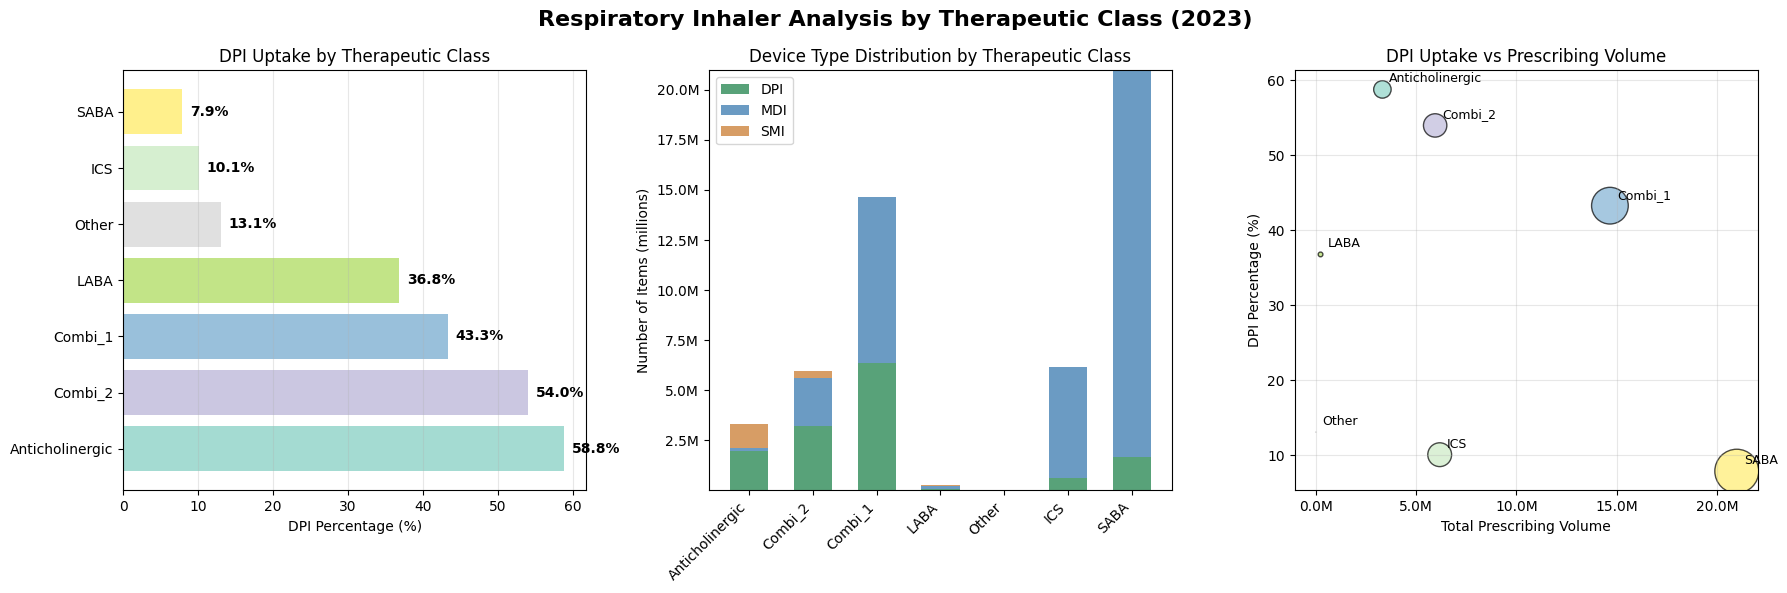

Summary Statistics:
Highest DPI uptake: Anticholinergic (58.8%)
Lowest DPI uptake: SABA (7.9%)
Largest prescribing volume: SABA (20,977,451 items)
Total respiratory inhaler items: 51,323,141


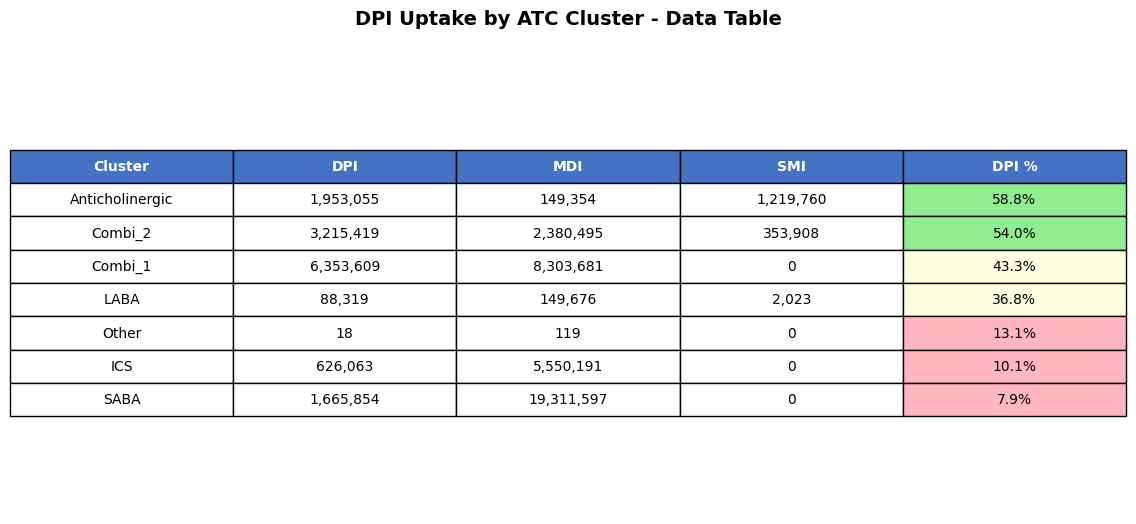

In [20]:

df = DPI_uptake_by_ATC_cluster

# Set up the figure with three subplots (1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Respiratory Inhaler Analysis by Therapeutic Class (2023)', fontsize=16, fontweight='bold')

# Color scheme for consistency across plots
colors = plt.cm.Set3(np.linspace(0, 1, len(df)))

# Plot 1: Horizontal bar chart of DPI percentages
ax1.barh(df['cluster'], df['DPI_percentage'], color=colors, alpha=0.8)
ax1.set_xlabel('DPI Percentage (%)')
ax1.set_title('DPI Uptake by Therapeutic Class')
ax1.grid(axis='x', alpha=0.3)
# Add percentage labels on bars
for i, (cluster, pct) in enumerate(zip(df['cluster'], df['DPI_percentage'])):
    ax1.text(pct + 1, i, f'{pct}%', va='center', fontweight='bold')

# Plot 2: Stacked bar chart showing device type distribution
# Calculate total items for each cluster
df['Total'] = df['DPI'] + df['MDI'] + df['SMI']

# Create stacked bars
bar_width = 0.6
x_pos = np.arange(len(df))

# Stack the bars
p1 = ax2.bar(x_pos, df['DPI'], bar_width, label='DPI', color='#2E8B57', alpha=0.8)
p2 = ax2.bar(x_pos, df['MDI'], bar_width, bottom=df['DPI'], label='MDI', color='#4682B4', alpha=0.8)
p3 = ax2.bar(x_pos, df['SMI'], bar_width, bottom=df['DPI'] + df['MDI'], label='SMI', color='#CD853F', alpha=0.8)

ax2.set_ylabel('Number of Items (millions)')
ax2.set_title('Device Type Distribution by Therapeutic Class')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(df['cluster'], rotation=45, ha='right')
ax2.legend()

# Format y-axis to show millions
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Plot 3: Scatter plot - DPI percentage vs Total volume
# Size of bubbles represents total volume
bubble_sizes = (df['Total'] / df['Total'].max()) * 1000  # Scale for visibility

scatter = ax3.scatter(df['Total'], df['DPI_percentage'], 
                     s=bubble_sizes, c=colors, alpha=0.7, edgecolors='black', linewidth=1)

# Add labels for each point
for i, cluster in enumerate(df['cluster']):
    ax3.annotate(cluster, (df['Total'].iloc[i], df['DPI_percentage'].iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax3.set_xlabel('Total Prescribing Volume')
ax3.set_ylabel('DPI Percentage (%)')
ax3.set_title('DPI Uptake vs Prescribing Volume')
ax3.grid(alpha=0.3)

# Format x-axis to show millions
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print("Summary Statistics:")
print(f"Highest DPI uptake: {df.loc[df['DPI_percentage'].idxmax(), 'cluster']} ({df['DPI_percentage'].max()}%)")
print(f"Lowest DPI uptake: {df.loc[df['DPI_percentage'].idxmin(), 'cluster']} ({df['DPI_percentage'].min()}%)")
print(f"Largest prescribing volume: {df.loc[df['Total'].idxmax(), 'cluster']} ({df['Total'].max():,.0f} items)")
print(f"Total respiratory inhaler items: {df['Total'].sum():,.0f}")

# Create a simple data table visualisation
fig2, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

# Create table data with formatted numbers
table_data = []
for _, row in df.iterrows():
    table_data.append([
        row['cluster'],
        f"{row['DPI']:,.0f}",
        f"{row['MDI']:,.0f}",
        f"{row['SMI']:,.0f}",
        f"{row['DPI_percentage']:.1f}%"
    ])

# Create the table
table = ax.table(cellText=table_data,
                colLabels=['Cluster', 'DPI', 'MDI', 'SMI', 'DPI %'],
                cellLoc='center',
                loc='center',
                colColours=['lightblue']*5)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Style the table
for i in range(len(df) + 1):  # +1 for header
    for j in range(5):
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#4472C4')
            cell.set_text_props(color='white')
        else:
            if j == 4:  # DPI percentage column
                # Color code by DPI percentage
                pct = df.iloc[i-1]['DPI_percentage']
                if pct > 50:
                    cell.set_facecolor('#90EE90')  # Light green for high DPI
                elif pct > 30:
                    cell.set_facecolor('#FFFFE0')  # Light yellow for medium DPI
                else:
                    cell.set_facecolor('#FFB6C1')  # Light pink for low DPI

plt.title('DPI Uptake by ATC Cluster - Data Table', fontsize=14, fontweight='bold', pad=20)
plt.show()

<div style="text-align: right; margin-top: 20px;">
    <a href="#toc" style="color: #1976d2; text-decoration: none;">
        ↑ Back to Table of Contents
    </a>
</div>

<a id=f9></a>
### **Step 9**: Quality Assurance - Checking Our Classifications
Finally, we verify our therapeutic groupings by examining the top 10 prescribed inhalers in each category. Again, this can be done with pandas, but for consistency, we will modify our existing SQL query.

In [21]:
sql_top_10_inhaler_prescribing_per_cluster = """
WITH resp_inhalers AS (
  SELECT
    -- BNF codes uniquely identify medication prescribed in the UK
    rx.bnf_code,                    -- Unique identifier for the medication
    rx.bnf_name,                    -- Human-readable name of the medication
    
    -- ATC codes are international drug classification codes
    CASE
      -- Special handling for Generic Enerzair Breezhaler
      WHEN vmp.id = 39134511000001107 THEN 'R03AL12'
      -- For all other medication, use the ATC code from the lookup table
      ELSE atc.atc_code
    END AS atc_code,
    
    -- Classify inhaler devices by their delivery mechanism
    CASE 
      WHEN r.descr = 'powderinhalation.inhalation' THEN 'DPI'    -- Dry Powder Inhaler
      WHEN r.descr = 'pressurizedinhalation.inhalation' THEN 'MDI' -- Metered Dose Inhaler
      WHEN r.descr = 'inhalationsolution.inhalation' THEN 'SMI'   -- Soft Mist Inhaler
    ELSE 'OTHER' END AS type,
    
    -- Sum up the total number of prescription items for each medication
    SUM(items) AS total_items
    
  -- Main prescription data table
  FROM `hscic.normalised_prescribing` rx
  
  -- JOIN operations to link prescription data with drug metadata:
  
  -- Link prescriptions to Virtual Medicinal Products (VMP) in the dm+d database
  -- This JOIN matches BNF codes by taking first 9 chars + last 2 chars to ensure brand and generic prescribing is captured.
  LEFT JOIN `dmd.vmp` vmp ON CONCAT(SUBSTR(rx.bnf_code,0,9),SUBSTR(rx.bnf_code,-2)) = 
                             CONCAT(SUBSTR(vmp.bnf_code,0,9),SUBSTR(vmp.bnf_code,-2))
  
  -- Link to ontology table to get drug form/route information
  LEFT JOIN `dmd.ont` AS o ON vmp.id = o.vmp
  
  -- Get the detailed form/route descriptions (e.g., "powderinhalation.inhalation")
  LEFT JOIN `dmd.ontformroute` AS r ON o.form = r.cd
  
  -- Link to supplementary data table to obtain ATC codes
  LEFT JOIN `scmd.scmd_dmd_supp` AS atc ON CAST(vmp.id AS STRING) = atc.vmp_code
  
  -- Filter conditions:
  WHERE EXTRACT(YEAR FROM month) = 2023          -- Only 2023 data
    AND vmp.bnf_code LIKE '03%'                  -- Only respiratory medicines (BNF chapter 03)
    AND r.descr IN (                             -- Only inhaler delivery routes
      'powderinhalation.inhalation',             -- DPI devices
      'pressurizedinhalation.inhalation',        -- MDI devices  
      'inhalationsolution.inhalation'            -- SMI devices
    )
  
  -- Group identical medications together to sum their prescription volumes
  GROUP BY
    bnf_code,
    bnf_name,
    atc_code,
    type
  
  -- Sort by prescription volume (highest first)
  ORDER BY
    total_items DESC
),
-- Step 2: Categorise drugs and rank within each category
categorised_inhalers AS (
  SELECT 
    bnf_code,     -- Medication identifier
    bnf_name,     -- Medication name
    atc_code,     -- International drug classification code
    
    -- Categorise drugs by therapeutic class based on ATC code patterns:
    CASE
      -- Short-Acting Beta Agonists
      WHEN SUBSTR(atc_code,0,6) = 'R03AC0' THEN 'SABA'
      
      -- Long-Acting Beta Agonists
      WHEN SUBSTR(atc_code,0,6) = 'R03AC1' THEN 'LABA'
      
      -- Anticholinergics
      WHEN SUBSTR(atc_code,0,5) = 'R03BB' THEN 'Anticholinergic'
      
      -- Inhaled Corticosteroids
      WHEN SUBSTR(atc_code,0,5) = 'R03BA' THEN 'ICS'
      
      -- Combination inhalers type 1 
      WHEN SUBSTR(atc_code,0,5) = 'R03AK' THEN 'Combi_1'
      
      -- Combination inhalers type 2 
      WHEN SUBSTR(atc_code,0,5) = 'R03AL' THEN 'Combi_2'
      
      -- Anything else not fitting the above categories
      ELSE 'OTHER'
    END AS cat,              -- Therapeutic category
    
    type,                    -- Device type (DPI/MDI/SMI)
    total_items,             -- Total prescription volume
    
    -- Rank inhalers within each category by total_items (descending)
    ROW_NUMBER() OVER (
      PARTITION BY CASE
        WHEN SUBSTR(atc_code,0,6) = 'R03AC0' THEN 'SABA'
        WHEN SUBSTR(atc_code,0,6) = 'R03AC1' THEN 'LABA'
        WHEN SUBSTR(atc_code,0,5) = 'R03BB' THEN 'Anticholinergic'
        WHEN SUBSTR(atc_code,0,5) = 'R03BA' THEN 'ICS'
        WHEN SUBSTR(atc_code,0,5) = 'R03AK' THEN 'Combi_1'
        WHEN SUBSTR(atc_code,0,5) = 'R03AL' THEN 'Combi_2'
        ELSE 'OTHER'
      END
      ORDER BY total_items DESC
    ) AS rank_in_category
    
  FROM resp_inhalers         -- Use the processed data from the CTE above
)
-- Step 3: Filter to show only top 10 from each category
SELECT 
  cat,
  atc_code,
  bnf_code,
  bnf_name,
  type,
  total_items
FROM categorised_inhalers
WHERE rank_in_category <= 10
ORDER BY 
  -- Order by category (to group them together)
  CASE cat
    WHEN 'SABA' THEN 1
    WHEN 'LABA' THEN 2
    WHEN 'Anticholinergic' THEN 3
    WHEN 'ICS' THEN 4
    WHEN 'Combi_1' THEN 5
    WHEN 'Combi_2' THEN 6
    ELSE 7
  END,
  -- Then by total_items within each category
  total_items DESC
  """
top_10_inhaler_prescribing_per_cluster = bq.cached_read(
 sql_top_10_inhaler_prescribing_per_cluster,
    csv_path=os.path.join('..', 'data', 'v2',' interim_file_top_10_inhaler_prescribing_per_cluster.csv')
) 

**This query will process 174.9 GB when run.**

In [22]:
#display without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(top_10_inhaler_prescribing_per_cluster)

,cat,atc_code,bnf_code,bnf_name,type,total_items
0,SABA,R03AC02,0301011R0BIAFAP,Salamol 100micrograms/dose inhaler CFC free (Teva),MDI,7373702
1,SABA,R03AC02,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,MDI,7315130
2,SABA,R03AC02,0301011R0BEAIAP,Ventolin 100micrograms/dose Evohaler,MDI,3462642
3,SABA,R03AC02,0301011R0BWAABZ,Easyhaler Salbutamol sulfate 100micrograms/dose dry pdr inh,DPI,791873
4,SABA,R03AC02,0301011R0AABUBU,Salbutamol 100micrograms/dose breath actuated inh CFC free,MDI,557545
5,SABA,R03AC02,0301011R0BIAGBU,Salamol 100micrograms/dose Easi-Breathe inhaler,MDI,490820
6,SABA,R03AC02,0301011R0BEAHAQ,Ventolin 200micrograms/dose Accuhaler,DPI,314379
7,SABA,R03AC03,0301011V0AABBBB,Terbutaline 500micrograms/dose dry powder inhaler,DPI,216612
8,SABA,R03AC03,0301011V0BBARBB,Bricanyl 500micrograms/dose Turbohaler,DPI,164841
9,SABA,R03AC02,0301011R0BWABAQ,Easyhaler Salbutamol sulfate 200micrograms/dose dry pdr inh,DPI,95776


*Inspection of these results confirms that the inhalers have been grouped in the correct clusters. 
We would expect to see the Adrenaline inhalers in the 'Other'category but they do not make an appearance as they have not been prescribed.*

<div style="text-align: right; margin-top: 20px;">
    <a href="#toc" style="color: #1976d2; text-decoration: none;">
        ↑ Back to Table of Contents
    </a>
</div>

### End of Notebook 😊